# Flow visualization - Oslo City Bike Station Network

### Authors: Niclas Classen & Manuel Knepper
**TL;DR:** This notebook visualizes the flow of bikes between the stations of the Oslo City Bike network. The data for the bike rides is taken from https://oslobysykkel.no/en/open-data and the data for the city districts is taken from https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b. The purpose of this notebook is to analyze the flow and cycling patterns of the Oslo City Bike network.

**Reproducibility:** The repository contains the raw and preprocessed data as well as the code to reproduce the analysis. The notebook is written to run from top to bottom.

## Part 1: Data Preprocessing

#### Data Sources:
- Oslo City Bike Data: https://oslobysykkel.no/en/open-data
- Oslo Districts Geojson: https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b

#### Data Structure
The data is stored in the following folder structure:
- `data/`: Contains all the raw and preprocessed data
- `data/monthly`: Contains the monthly raw data for the bike rides
- `data/oslo_districts.geojson`: Contains the geojson file of the Oslo districts

It is recommended to use this folder structure as it only requires minor changes in the code to run the analysis.

As result of the data preprocessing, we have the following files:
- `data/preprocessed_bike_rides.csv`: Contains the preprocessed bike rides data of all months

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# !!! Set the path to the data directory in the .env file !!!
_path = os.environ.get("PATH_TO_DATA_DIRECTORY")

#### Create one file for all bike rides

In [5]:
# The following runs for 2 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

dir_path = os.path.join(_path, 'monthly')
export_path = os.path.join(_path)

# Get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
dataframes = []

for file in tqdm(csv_files):
    # Extract year and month from filename
    year, month = file.split('.')[0].split('_')

    # Read csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))

    # Add a new column for the month and year
    df['month'] = month
    df['year'] = year

    # Check if the DataFrame is not empty or does not contain only NaN values (avoid warning when concatenating dfs)
    if not df.empty and not df.isna().all().all():
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
if dataframes:
    combined_df = pd.concat(dataframes)

    # Write the combined dataframe to a new csv file in the export directory
    combined_df.to_csv(f'{export_path}/preprocessed_bike_rides.csv', index=False)

100%|██████████| 61/61 [00:28<00:00,  2.13it/s]
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_19905/23710081.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dataframes)


In [7]:
# First look at the data
combined_df.head(3)

started_at                          ended_at  \
0  2023-10-01 00:00:40.773000+00:00  2023-10-01 00:04:34.682000+00:00   
1  2023-10-01 03:01:18.390000+00:00  2023-10-01 03:08:24.193000+00:00   
2  2023-10-01 03:06:04.201000+00:00  2023-10-01 03:09:44.839000+00:00   

  duration start_station_id   start_station_name start_station_description  \
0      233              507    Jens Bjelkes Gate       ved Trondheimsveien   
1      425              607  Marcus Thranes gate             ved Akerselva   
2      220              500          Anker Hotel            langs Storgata   

   start_station_latitude  start_station_longitude end_station_id  \
0               59.919147                10.764130           2339   
1               59.932772                10.758595            393   
2               59.917279                10.758155            506   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude month year  
0             59.915649              10.761725    10   23  
1             59.939244              10.774319    10   23  
2             59.920128              10.768875    10   23

## Part 2: Data Analysis

In [13]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from geopandas.tools import sjoin
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

### Helper functions
First we define some helper functions to load the data that we need for the analysis.

In [4]:
def create_stations_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame

    # Create unique dataframes for start and end stations
    start_stations = df[
        [
            "start_station_id",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()
    end_stations = df[
        [
            "end_station_id",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()

    # Rename columns for uniformity
    start_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]
    end_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]

    # Concatenate the dfs and drop duplicates
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs=crs_in,
    )
    gdf_stations = gdf_stations.to_crs(epsg=crs_out)

    return gdf_stations

def create_rides_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame
    
    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "start_station_id",
            "end_station_id",
            "started_at",
            "ended_at",
            "duration",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].copy() # copy to avoid warning

    # Create LineString objects
    df_rides.loc[:, "geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides

def create_oslo_districts_gdf(
    data_path: str = "data/oslo_districts.geojson",
    crs_in: int = 32633,
    crs_out: int = 3857,
) -> gpd.GeoDataFrame:
    gdf_oslo_districts = gpd.read_file(data_path)

    print(gdf_oslo_districts.crs)
    # Set the correct CRS
    gdf_oslo_districts.set_crs(crs_in, inplace=True, allow_override=True)

    # Reproject the data
    gdf_oslo_districts = gdf_oslo_districts.to_crs(epsg=crs_out)

    # Rename columns
    gdf_oslo_districts = gdf_oslo_districts.rename(columns={"bydelnavn": "district"})

    return gdf_oslo_districts

### 2.1 General data analysis

In [5]:
# The following runs for 5 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

# Read the preprocessed data
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations_unfiltered = create_stations_gdf(df) # don't filtered by month or year (so that we can analyse the differences in stations over time)
gdf_stations = gdf_stations_unfiltered.drop_duplicates(subset=['station_id']) # get all unique stations that ever existed
gdf_stations_last_month = create_stations_gdf(df.loc[(df['year'] == 24) & (df['month'] == 4)]) # get stations from april 2024
gdf_stations_last_year = create_stations_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]).drop_duplicates(subset=['station_id']) # get stations from mai 2023 to april 2024 (last year)

gdf_rides = create_rides_gdf(df)
gdf_rides_last_year = create_rides_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]) # rides from mai 2023 to april 2024 (last year)

# Create GeoDataFrame for Oslo districts
gdf_oslo_districts = create_oslo_districts_gdf()

EPSG:4326


#### 2.1.1 Let's have a first look at the data

##### Oslo Bike Stations

In [6]:
print("Stations gdf unfiltered shape:", gdf_stations_unfiltered.shape)
print("Stations filtered by station_id gdf shape:", gdf_stations.shape)
print("Stations filtered by station_id last month gdf shape:", gdf_stations_last_month.shape)
print("Stations filtered by station_id last year gdf shape:", gdf_stations_last_year.shape)
gdf_stations.head(3)

Stations gdf unfiltered shape: (15332, 8)
Stations filtered by station_id gdf shape: (286, 8)
Stations filtered by station_id last month gdf shape: (267, 8)
Stations filtered by station_id last year gdf shape: (273, 8)


station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   

   month  year                         geometry  
0     10    23  POINT (1198257.424 8381758.913)  
1     10    23  POINT (1197641.308 8384785.559)  
2     10    23  POINT (1197592.370 8381344.042)

In [42]:
gdf_stations.explore()

##### Bike Rides

In [8]:
print("Rides gdf shape:", gdf_rides.shape)
print("Rides gdf of last year shape:", gdf_rides_last_year.shape)
gdf_rides.head(3)

Rides gdf shape: (7897309, 16)
Rides gdf of last year shape: (1106880, 16)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude  month  year  \
0             59.915649              10.761725     10    23   
1             59.939244              10.774319     10    23   
2             59.920128              10.768875     10    23   

                                            geometry  
0  LINESTRING (1198257.424 8381758.913, 1197989.6...  
1  LINESTRING (1197641.308 8384785.559, 1199391.7...  
2  LINESTRING (1197592.370 8381344.042, 1198785.7...

##### Oslo City Districts

In [9]:
print("Oslo districts gdf shape:", gdf_oslo_districts.shape)
gdf_oslo_districts.head(3)

Oslo districts gdf shape: (17, 3)


district bydelnr  \
0            Frogner  030105   
1           Østensjø  030113   
2  Søndre Nordstrand  030115   

                                            geometry  
0  MULTIPOLYGON (((1189421.693 8375826.292, 11864...  
1  MULTIPOLYGON (((1206718.020 8369118.365, 12067...  
2  MULTIPOLYGON (((1210120.108 8358267.151, 12100...

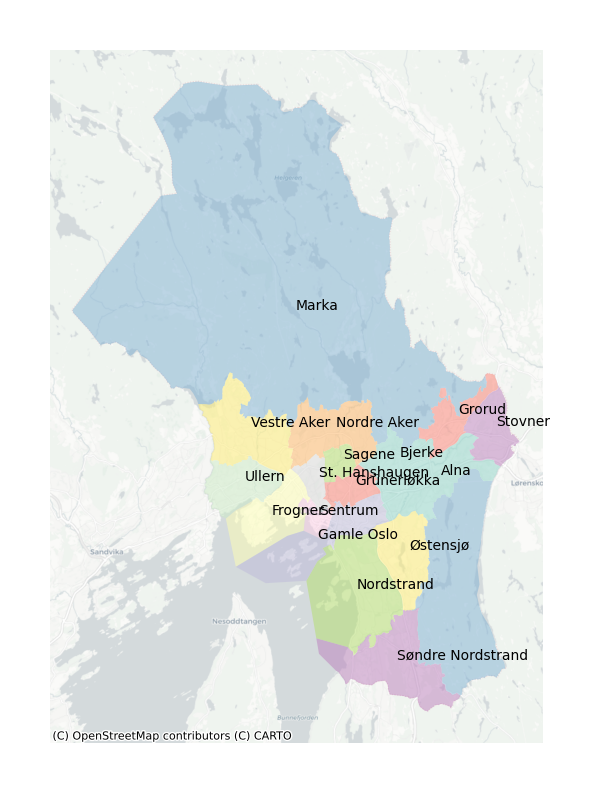

In [14]:
# Plot the different districts in Oslo
ax = gdf_oslo_districts.plot(column='district', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add a basemap
cx.add_basemap(ax, crs=gdf_oslo_districts.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(gdf_oslo_districts.geometry.centroid.x, gdf_oslo_districts.geometry.centroid.y, gdf_oslo_districts['district']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

#### 2.1.2 Changes of the station network over the years

In [11]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations_unfiltered[gdf_stations_unfiltered['year'] == year].drop_duplicates(subset=['station_id'])

    if year != 19:
        difference_stations_by_year[f'{year - 1}_{year}'] = set(gdf_stations_by_year[year]['station_id'].unique()) - set(gdf_stations_by_year[year - 1]['station_id'].unique())
        difference_stations_by_year[f'{year}_{year - 1}'] = set(gdf_stations_by_year[year - 1]['station_id'].unique()) - set(gdf_stations_by_year[year]['station_id'].unique())

In [12]:
# Get number of unique stations for entire dataset and for different years
for year, df in gdf_stations_by_year.items():
    number = df['station_id'].nunique()
    print(f"Number of stations in {year}: {number}")

Number of stations in 19: 254
Number of stations in 20: 255
Number of stations in 21: 262
Number of stations in 22: 269
Number of stations in 23: 273
Number of stations in 24: 268


In [51]:
gdf_stations_2019 = gdf_stations_by_year[19]
gdf_stations_2024 = gdf_stations_by_year[24]

stations_2019 = gdf_stations_2019['station_id'].unique()
stations_2024 = gdf_stations_2024['station_id'].unique()

# remove existing stations from 2024
difference_19_24 = set(stations_2024) - set(stations_2019)
difference_24_19 = set(stations_2019) - set(stations_2024)

stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]
stations_change_2019_2024_df = gdf_stations_2019.loc[gdf_stations_2019['station_id'].isin(list(difference_24_19))]

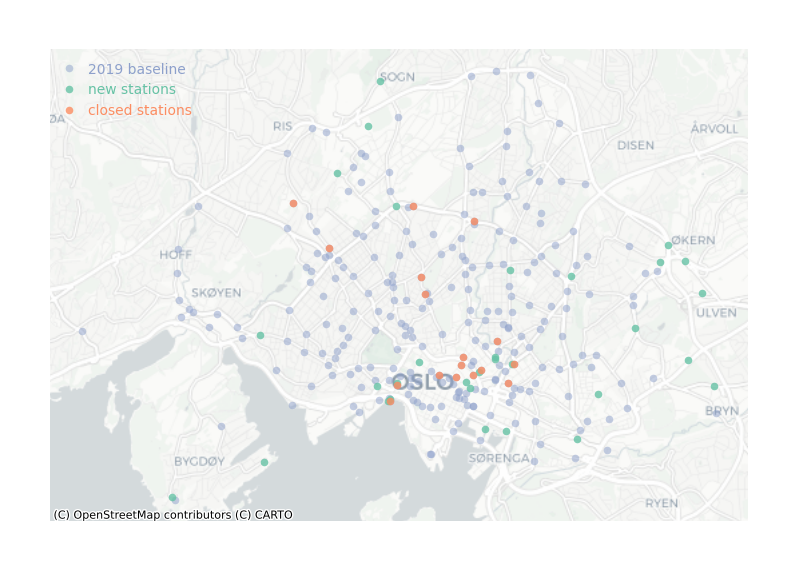

In [59]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_by_year[19].plot(alpha=0.5, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
stations_change_2024_2019_df.plot(alpha=0.8, ax=ax, color='#66c2a5', markersize=30, label='new stations')
stations_change_2019_2024_df.plot(alpha=0.8, ax=ax, color='#fc8d62', markersize=30, label='closed stations')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_by_year[19].crs, source=cx.providers.CartoDB.Positron)

In [112]:
# TODO: Add plot for each year / moth / season

#### 2.1.3 Basic behavior of the bike rides

##### Distribution of rental durations

In [19]:
# Function to format y-tick labels
def thousands(x, pos):
    return '%1.0fK' % (x * 0.001)

In [20]:
def plot_histogram_of_trip_durations(gdf_rides_input, plot_title):
    
    formatter = FuncFormatter(thousands)

    # Format durations to minutes and cap them at 100 minutes
    gdf_rides_input['duration_in_minutes'] = gdf_rides_input['duration'] / 60
    gdf_rides_input['duration_capped'] = np.where(gdf_rides_input['duration_in_minutes'] > 100, 100, gdf_rides_input['duration_in_minutes'])

    # Calculate percentiles for the capped durations
    percentiles = np.percentile(gdf_rides_input['duration_capped'], [75])

    # Set the style and color palette of the plot
    sns.set_color_codes('pastel')

    # Create a histogram of the capped durations
    sns.histplot(gdf_rides_input['duration_capped'], bins=50, color='b', edgecolor="none")

    # Add vertical lines for the percentiles
    for percentile in percentiles:
        plt.axvline(x=percentile, color='r', linestyle='--')
        plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Duration (minutes)', fontsize=12)
    plt.ylabel('Number of trips', fontsize=12)

    # Set x-axis labels to increments of 5
    plt.xticks(np.arange(0, max(gdf_rides_input['duration_capped'])+5, 5))

    # Format y-axis labels to thousands
    plt.gca().yaxis.set_major_formatter(formatter)

    # Remove the top, bottom, right, and left spines from plot
    sns.despine(left=True, bottom=True) # right and top are True by default

    # Show the plot
    plt.show()

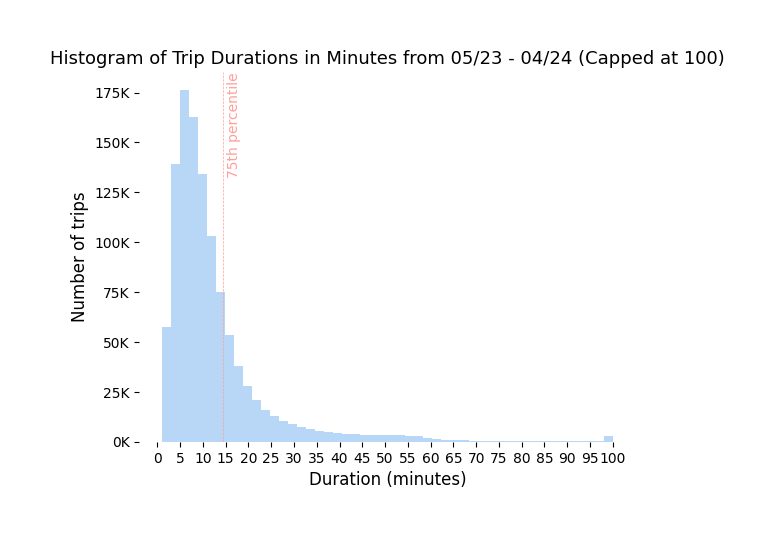

In [21]:
plot_title = 'Histogram of Trip Durations in Minutes from 05/23 - 04/24 (Capped at 100)'
plot_histogram_of_trip_durations(gdf_rides_last_year, plot_title)

In [ ]:
# TODO: Add plot for each year / month /season

##### Number of rides per day

In [22]:
# this is a small helper function to parse the dates
def custom_date_parser(d):
    return parse(d)

In [23]:
def plot_number_of_rides_per_day(gdf_rides_input, plot_title):
    tqdm.pandas()

    # Convert 'started_at' to datetime format
    gdf_rides_input['started_at_converted'] = gdf_rides_input['started_at'].progress_apply(custom_date_parser)

    # Extract the hour and day of the week
    gdf_rides_input['day'] = gdf_rides_input['started_at_converted'].dt.day
    gdf_rides_input['hour'] = gdf_rides_input['started_at_converted'].dt.hour
    gdf_rides_input['day_of_week'] = gdf_rides_input['started_at_converted'].dt.dayofweek
    gdf_rides_input['weekday_or_weekend'] = gdf_rides_input['day_of_week'].progress_apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    bins = list(range(0, 25, 1))  # Create bins for each hour
    labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
    gdf_rides_input['hour_interval'] = pd.cut(gdf_rides_input['hour'], bins=bins, labels=labels, right=False)

    # Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
    grouped = gdf_rides_input.groupby(['day_of_week', 'hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

    plt.figure(figsize=(15, 8))
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Hour of the Day', fontsize=12)
    plt.ylabel('Number of Trips', fontsize=12)
    
    sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')

    # Remove the top, bottom, right, and left spines from plot
    sns.despine(left=True, bottom=True) # right and top are True by default

    plt.show()

100%|██████████| 1106880/1106880 [00:00<00:00, 1783662.32it/s]


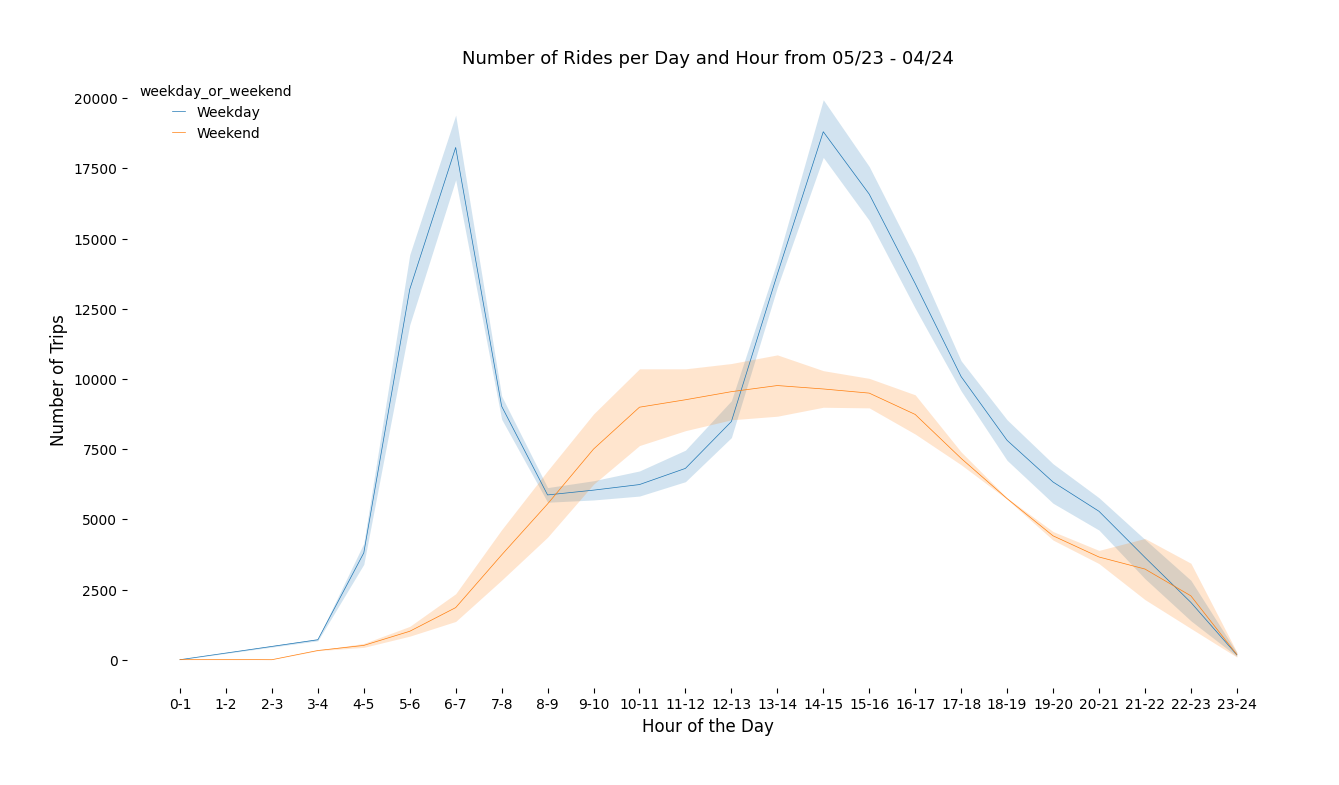

In [24]:
# The following runs for 15 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5 for all the rides and 2 mins for the last year
plot_title = 'Average number of Rides per Day and Hour from 05/23 - 04/24'
plot_number_of_rides_per_day(gdf_rides_last_year, plot_title)

In [25]:
# Number of rides per hour interval
number_of_trips_weekend_weekday = gdf_rides_last_year.groupby(['hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

# Let's print the actual number of trips
print('Number of trips on weekdays:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekday'])
print('-----------------------------------')
print('Number of trips on weekends:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekend'])

Number of trips on weekdays:
   hour_interval weekday_or_weekend  num_trips
0            0-1            Weekday          3
4            3-4            Weekday       3560
6            4-5            Weekday      19027
8            5-6            Weekday      65954
10           6-7            Weekday      91220
12           7-8            Weekday      45143
14           8-9            Weekday      29348
16          9-10            Weekday      30201
18         10-11            Weekday      31194
20         11-12            Weekday      34075
22         12-13            Weekday      42413
24         13-14            Weekday      68651
26         14-15            Weekday      94021
28         15-16            Weekday      82910
30         16-17            Weekday      66990
32         17-18            Weekday      50420
34         18-19            Weekday      39073
36         19-20            Weekday      31652
38         20-21            Weekday      26439
40         21-22            Wee

##### Average trip duration per day

In [29]:
def plot_avg_trip_duration_per_day(gdf_rides_input, plot_title):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    gdf_rides_input['day_of_week_name'] = gdf_rides_input['day_of_week'].map(day_mapping)
    
    average_duration = gdf_rides_input.groupby('day_of_week_name')['duration_in_minutes'].mean()
    average_duration = average_duration.reindex(weekdays)
    
    print(f'{plot_title}: ')
    print(average_duration)

    # Create the plot with flipped axes and pastel color
    sns.set_color_codes('pastel')
    sns.barplot(x=average_duration.values, y=average_duration.index, color='b', orient='h')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Average trip duration (minutes)', fontsize=12)
    plt.ylabel('Day of the Week', fontsize=12)

    # Show the plot
    plt.show()


Average Trip Duration per Day of the Week from 05/23 - 04/24: 
day_of_week_name
Monday       12.003564
Tuesday      11.635371
Wednesday    11.745624
Thursday     12.060669
Friday       12.337010
Saturday     14.679039
Sunday       15.518452
Name: duration_in_minutes, dtype: float64


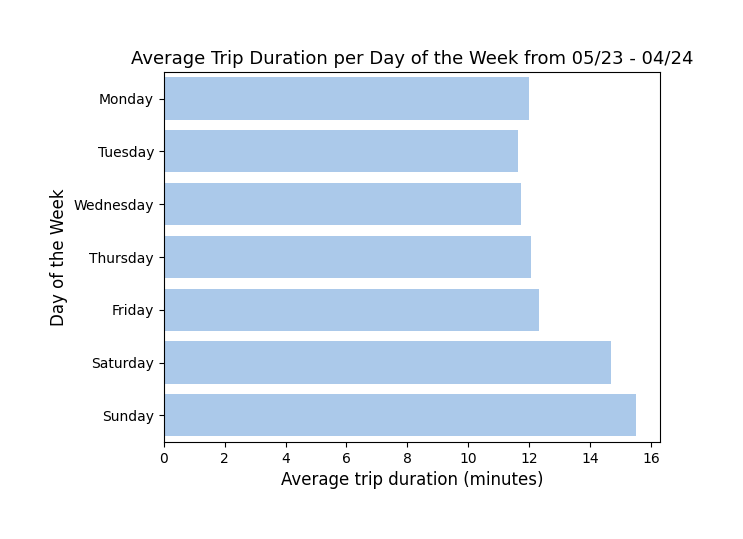

In [30]:
plot_avg_trip_duration_per_day(gdf_rides_last_year, 'Average Trip Duration per Day of the Week from 05/23 - 04/24')

### 2.2 Flow analysis

#### 2.2.1 Flow between stations

In [31]:
def get_unique_rides_count(gdf_rides_input):
    gdf_rides_unique = gdf_rides_input.drop_duplicates(subset=['start_station_id','end_station_id']).copy()
    gdf_rides_unique['count'] = gdf_rides_input.groupby(['start_station_id','end_station_id'])['start_station_id'].transform('count')

    return gdf_rides_unique

In [32]:
gdf_rides_unique = get_unique_rides_count(gdf_rides_last_year)
print(gdf_rides_unique.shape)
gdf_rides_unique.head(3)

(60994, 26)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name  ... duration_in_minutes  duration_capped  \
0                  Elgsletta  ...            3.883333         3.883333   
1  Hans Nielsen Hauges plass  ...            7.083333         7.083333   
2         Botanisk Hage vest  ...            3.666667         3.666667   

              started_at_converted  day  hour day_of_week  weekday_or_weekend  \
0 2023-10-01 00:00:40.773000+00:00    1     0           6             Weekend   
1 2023-10-01 03:01:18.390000+00:00    1     3           6             Weekend   
2 2023-10-01 03:06:04.201000+00:00    1     3           6             Weekend   

   hour_interval day_of_week_name  count  
0            0-1           Sunday     64  
1            3-4           Sunday     17  
2            3-4           Sunday     40  

[3 rows x 26 columns]

In [33]:
# scale the count column
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1))
gdf_rides_unique_scaled = gdf_rides_unique.copy()
gdf_rides_unique_scaled['count'] = np.clip(min_max_scaler.transform(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1)), 0, 1)

print("max", gdf_rides_unique_scaled['count'].max())

max 1.0


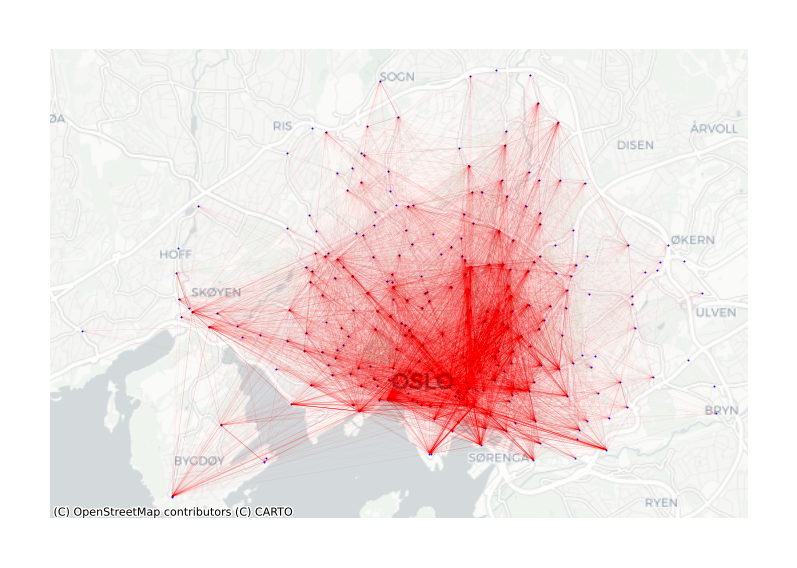

In [34]:
# plot the flow between stations scaled on transparency by the number of rides
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_scaled['count'], ax=ax, color='red')
gdf_stations_last_year.plot(alpha=0.9, markersize=2, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_last_year.crs, source=cx.providers.CartoDB.Positron)

In [172]:
# TODO: Add plot for each year / month / season

##### Flow of new stations

In [ ]:
# TODO: Clean up the following code

In [35]:
gdf_stations_2019 = gdf_stations_unfiltered.loc[gdf_stations_unfiltered['year'] == 19]
gdf_stations_2024 = gdf_stations_unfiltered.loc[gdf_stations_unfiltered['year'] == 24]
stations_2019 = gdf_stations_2019['station_id'].unique()
stations_2024 = gdf_stations_2024['station_id'].unique()
difference_19_24 = set(stations_2024) - set(stations_2019)
stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]

In [36]:
rides_new_stations_start = gdf_rides.loc[gdf_rides['start_station_id'].isin(list(difference_19_24))]
rides_new_stations_end = gdf_rides.loc[gdf_rides['end_station_id'].isin(list(difference_19_24))]

In [37]:
frames = [rides_new_stations_start, rides_new_stations_end]
rides_new_stations = pd.concat(frames)

In [38]:
# Preprocessing
gdf_rides_unique_19_24 = rides_new_stations.drop_duplicates(subset=['start_station_id','end_station_id'])
rides_count_19_24 =rides_new_stations.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()
testdf_19_24 = pd.DataFrame(data=rides_count_19_24.index, columns=['station_ids'])
testdf2_19_24 = pd.DataFrame(data=rides_count_19_24.values, columns=['count'])
rides_count_19_24_df = pd.merge(testdf_19_24, testdf2_19_24, left_index=True, right_index=True)
rides_count_19_24_df[['start_station_id','end_station_id']] = rides_count_19_24_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 
rides_count_19_24_df['start_station_id'] = rides_count_19_24_df['start_station_id'].str[1:]
rides_count_19_24_df['end_station_id'] = rides_count_19_24_df['end_station_id'].str.rstrip(')')
rides_count_19_24_df['start_station_id'] = pd.to_numeric(rides_count_19_24_df['start_station_id'])
rides_count_19_24_df['end_station_id'] = pd.to_numeric(rides_count_19_24_df['end_station_id'])
gdf_rides_unique_count_19_24 = pd.merge(gdf_rides_unique_19_24, rides_count_19_24_df, 'inner',on=['start_station_id', 'end_station_id'])

In [39]:
min_max_scaler_19_24 = MinMaxScaler()
min_max_scaler_19_24.fit(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24.copy()
gdf_rides_unique_count_19_24_scaled['count'] = min_max_scaler_19_24.transform(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))

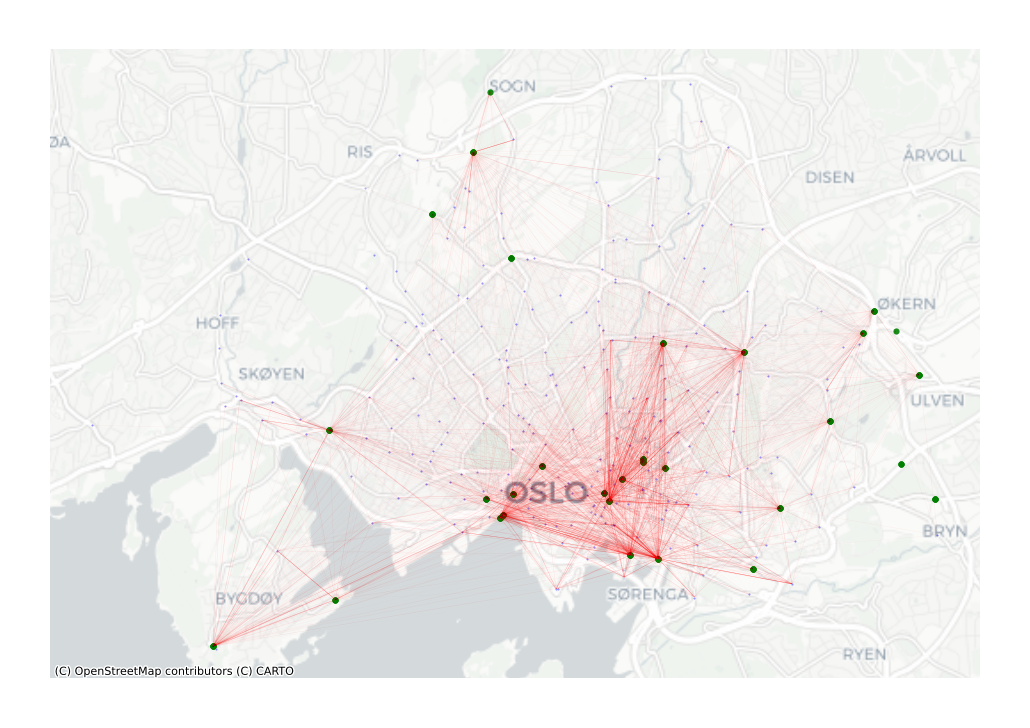

In [40]:
# TODO: fix missmatch of new stations to first analysis
f, ax = plt.subplots(1, figsize=(12, 12))
gdf_rides_unique_count_19_24_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_count_19_24_scaled['count'], ax=ax, color='red')
gdf_stations_2019.plot(alpha=0.05, markersize=2, ax=ax, color='blue')
stations_change_2024_2019_df.plot(alpha=0.9, markersize=20, ax=ax, color='green')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_2024.crs, source=cx.providers.CartoDB.Positron)

##### Flow between districts

In [ ]:
# TODO: fix future warning
# Proposed solution

# # Perform a spatial join between the stations and the districts
# joined = sjoin(gdf_stations_last_year, gdf_oslo_districts, how='left', predicate='within')

# # The 'district' column in 'joined' now contains the district of each station
# gdf_stations_last_year['district'] = joined['district']
# gdf_stations_last_year.head(5)


# Perform a spatial join between the stations and the districts
joined = sjoin(gdf_stations_last_year, gdf_oslo_districts, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
gdf_stations_last_year['district'] = joined['district']
gdf_stations_last_year.head(5)

In [196]:
# Create a dictionary from unique_polygons DataFrame
district_dict = gdf_stations_last_year.set_index('station_id')['district'].to_dict()

# Use the map function on the start_station_id and end_station_id columns
gdf_rides_last_year['start_district'] = gdf_rides_last_year['start_station_id'].map(district_dict)
gdf_rides_last_year['end_district'] = gdf_rides_last_year['end_station_id'].map(district_dict)

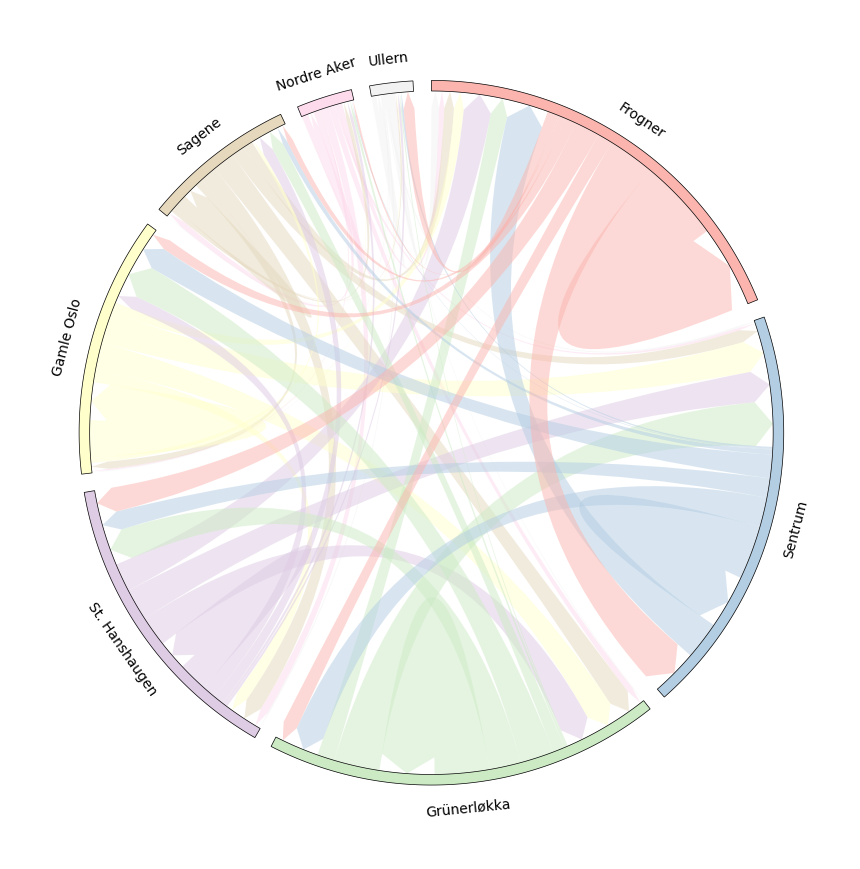

In [195]:
# Concatenate start_district and end_district
districts = pd.concat([gdf_rides_last_year['start_district'], gdf_rides_last_year['end_district']])

top_districts = districts.value_counts().head(8)
filtered_gdf_rides = gdf_rides_last_year[gdf_rides_last_year['start_district'].isin(top_districts.index) & gdf_rides_last_year['end_district'].isin(top_districts.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_district', 'end_district']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_districts.index, columns=top_districts.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="Pastel1",  # Change colormap to 'Pastel1'
    label_kws=dict(size=10, r=105),
    link_kws=dict(direction=1, ec="black", lw=0),
)
fig = circos.plotfig()

In [195]:
# TODO: Add plot for each year / month / season

In [7]:
# TODO: add map with with lines/arrows between the districts

### 2.3 Cluster analysis

To get an initial idea of the distribution of the variable 'Pct_Leave', let's make a quick choropleth map:

### Choropleth map (starting from)

In [125]:
# TODO maybe start with a clean df for all tasks

In [31]:
stations_24 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')

In [86]:
# remove all rides where start_station_id or end_station_id is not in the stations_24
gdf_rides_with_valid_stations = gdf_rides_last_year.loc[gdf_rides_last_year['start_station_id'].isin(stations_24['station_id']) & gdf_rides_last_year['end_station_id'].isin(stations_24['station_id'])]
gdf_rides_with_valid_stations.shape

(1083570, 24)

In [34]:
# create choropleth map

# Perform a spatial join between the stations and the districts
joined = sjoin(stations_24, gdf_oslo_districts, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
stations_24['district'] = joined['district']
stations_24.head(3)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


station_id station_name station_description   latitude  longitude  \
6360154         403    Parkveien   ved trikkestoppet  59.921768  10.730476   
6360155         464  Sukkerbiten       ved gangbroen  59.905124  10.753764   
6360156         426   Gimle Kino   ved Frogner Kirke  59.917281  10.708376   

         month  year                         geometry district  
6360154      4    24  POINT (1194511.124 8382340.955)  Frogner  
6360155      4    24  POINT (1197103.483 8378645.102)  Sentrum  
6360156      4    24  POINT (1192050.941 8381344.349)  Frogner

In [88]:
# Group gdf_rides by 'start_station_id' and count the number of rides
rides_start = gdf_rides_with_valid_stations.groupby('start_station_id').size().reset_index(name='num_rides_start')
stations_2024 = stations_24.merge(rides_start, left_on='station_id', right_on='start_station_id', how='left')

# Group gdf_rides by 'end_station_id' and count the number of rides
rides_end = gdf_rides_with_valid_stations.groupby('end_station_id').size().reset_index(name='num_rides_end')
stations_2024 = stations_2024.merge(rides_end, left_on='station_id', right_on='end_station_id', how='left')
stations_2024.shape

(268, 13)

In [89]:
#  group and sum number of start and end rides
district_rides_start = stations_2024.groupby('district')['num_rides_start'].sum().reset_index(name='num_rides_start')
district_rides_end = stations_2024.groupby('district')['num_rides_end'].sum().reset_index(name='num_rides_end')

# merge
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_start, on='district', how='left')
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_end, on='district', how='left')
gdf_oslo_districts.shape

(17, 5)

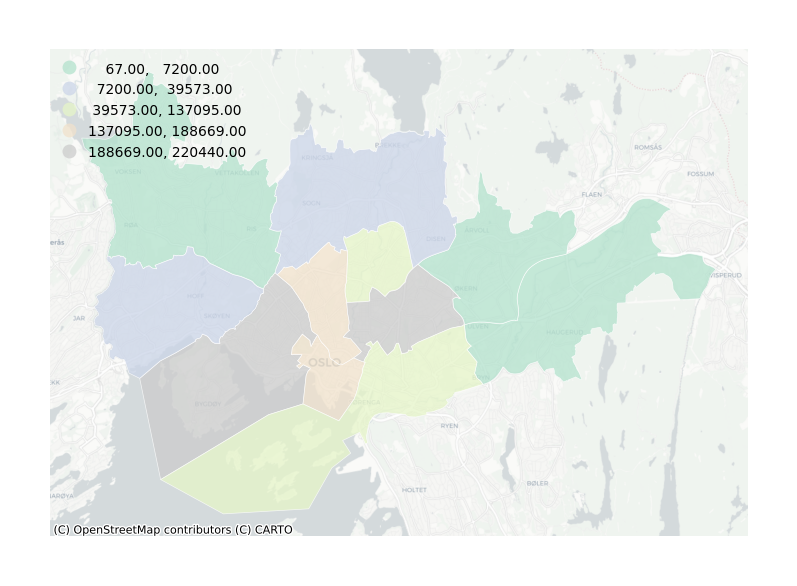

In [90]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_districts.plot(
    column="num_rides_start",
    cmap="Pastel2",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()

### Morans I

Moran's I: 0.2992533614323409, p-value: 0.001


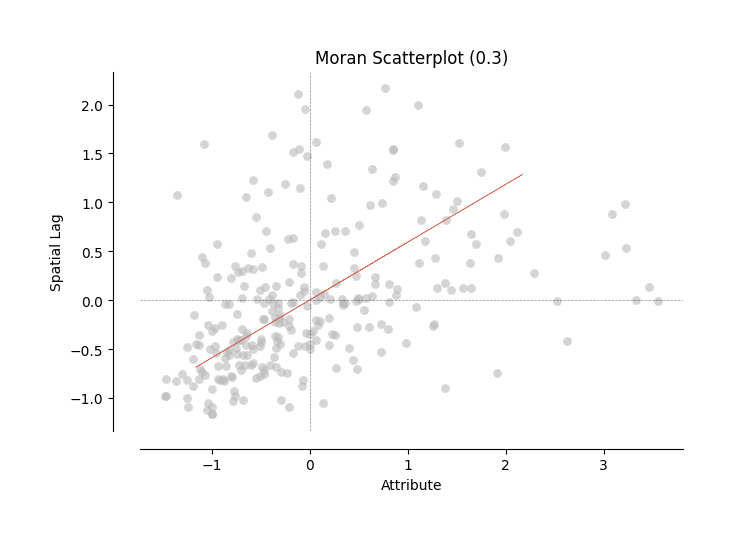

In [103]:
# KNN morans I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# Create a weights object using k-nearest neighbors
w = weights.KNN.from_dataframe(stations_2024, k=3, ids='station_id')

# Calculate Moran's I
moran = esda.Moran(stations_2024['num_rides_start'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Lisa

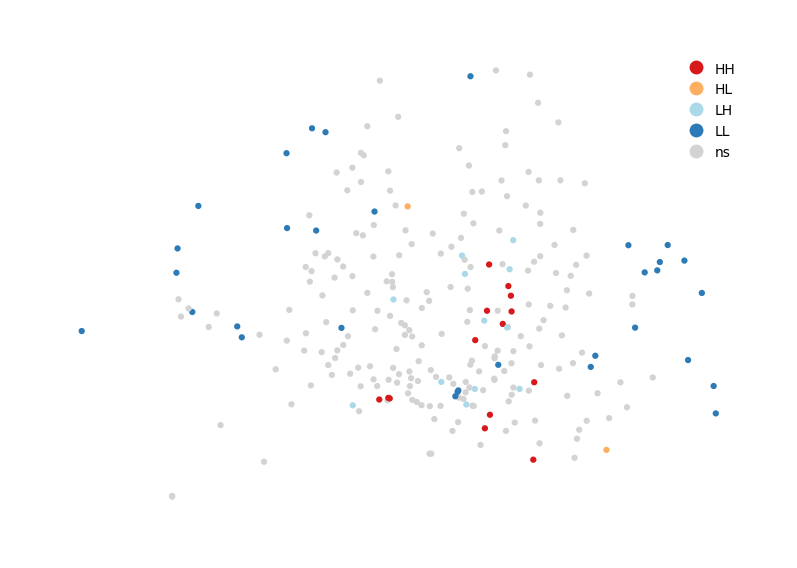

In [104]:
# LISA
from splot.esda import lisa_cluster

# Calculate local Moran's I
lisa = esda.Moran_Local(stations_2024['num_rides_start'], w)

# Create a LISA cluster map
fig, ax = lisa_cluster(lisa, stations_2024, p=0.05, figsize=(9, 9))

## Find new stations

In [83]:
import osmnx as ox

# Define the area of interest
area_of_interest = 'Oslo, Norway'

# Download the OSM data for land in the area of interest
gdf_land = ox.geometries_from_place(area_of_interest, tags={'landuse':True})

# Remove water bodies
gdf_land = gdf_land[gdf_land['landuse'] != 'water']

# Change the CRS of gdf_land to match that of gdf_stations
gdf_land = gdf_land.to_crs(gdf_stations.crs)

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_84099/3028784601.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_land = ox.geometries_from_place(area_of_interest, tags={'landuse':True})


In [12]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import combinations
from scipy.spatial import cKDTree
import numpy as np

In [90]:
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations_unfiltered = create_stations_gdf(df)
gdf_stations = gdf_stations_unfiltered.drop_duplicates(subset=['station_id'])

In [101]:
k_stations = gdf_stations['station_id'].nunique()
x = 3
k = 3
c = 3

gdf_stations
new_stations = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_stations.crs) 

# only 10 stations from stations_2024
# gdf_stations_input = gdf_stations.sample(n=k_stations)
gdf_stations_input = gdf_stations

In [102]:

for i in range(x):
    print(gdf_stations_input[-1:])

    # Step 1: Create all possible combinations of x stations
    combinations_of_stations = list(combinations(gdf_stations_input.geometry, x))

    # Step 2: Create polygons with progress bar
    polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

    # Step 3: Store polygons in a new GeoDataFrame
    gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_stations_input.crs)

    # Calculate the centroids of all polygons
    gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

    # Step 1: Calculate the distance from each centroid to its closest c stations
    tree = cKDTree(np.array(list(zip(gdf_stations_input.geometry.x, gdf_stations_input.geometry.y))))
    distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), k=c)

    # Step 2: TODO: add comment
    min_distances = distances.min(axis=1)
    furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-k_stations:]]


    # Create a new GeoDataFrame for furthest_centroids
    gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=gdf_stations_input.crs)

    # rename centroid to geometry
    gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

    for furthest_centroid in gdf_furthest_centroids['geometry']:
        print(furthest_centroid)
        # check if point is in water
        on_land = any(furthest_centroid.within(polygon) for polygon in gdf_land['geometry'])
        print("on land", on_land)
        if on_land:
            # add 
            gdf_stations_input = pd.concat([gdf_stations_input, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=stations_2024.crs)])
            new_stations = pd.concat([new_stations, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=stations_2024.crs)])
            break

    

         station_id     station_name  \
2228336         546  Kon-Tiki Museet   

                              station_description   latitude  longitude  \
2228336  Event Pop-Up stasjon ved Kon-Tiki Museet  59.903474   10.69847   

         month  year                         geometry  
2228336      6    23  POINT (1190948.236 8378278.770)  


100%|██████████| 3858140/3858140 [03:58<00:00, 16200.13it/s]


POINT (1193049.5134224454 8378179.6248697275)
on land False
POINT (1190349.1068826083 8383725.928339776)
on land False
POINT (1190182.0168973755 8384165.389130845)
on land True
   station_id station_name station_description  latitude  longitude  month  \
0         NaN          NaN                 NaN       NaN        NaN    NaN   

   year                         geometry  
0   NaN  POINT (1190182.017 8384165.389)  


100%|██████████| 3898895/3898895 [03:56<00:00, 16496.27it/s]


POINT (1194280.2185402394 8378388.235423471)
on land False
POINT (1194280.0148516458 8378380.989614988)
on land False
POINT (1192820.7139281614 8378509.445523516)
on land False
POINT (1188719.5853300411 8380795.91092653)
on land True
   station_id station_name station_description  latitude  longitude  month  \
0         NaN          NaN                 NaN       NaN        NaN    NaN   

   year                         geometry  
0   NaN  POINT (1188719.585 8380795.911)  


100%|██████████| 3939936/3939936 [04:30<00:00, 14573.57it/s]


POINT (1192503.0412836394 8378810.734448554)
on land False
POINT (1194353.8042864038 8378335.66360192)
on land False
POINT (1189972.6457568563 8380470.945394906)
on land True


In [98]:
gdf_stations_input

station_id               station_name  \
315656         538          Bernt Ankers gate   
803            405               Frognerbadet   
97             620                Bislettgata   
223            625            Spikersuppa Øst   
36             499          Bjerregaards gate   
...            ...                        ...   
30            2351             Sogn Studentby   
1568           483             Hausmanns gate   
283            469         Studentparlamentet   
212            443     Sjøsiden 1 ved trappen   
581            493  Sofienbergparken nordvest   

                                station_description   latitude  longitude  \
315656                                 ved Storgata  59.914789  10.753707   
803                          langs Middelthuns gate  59.928080  10.708767   
97                                  ved Sofies Gate  59.923774  10.734713   
223                                  ved Stortinget  59.913360  10.737663   
36                     ovenfor Fredrikke Qvams gate  59.925488  10.746058   
...                                             ...        ...        ...   
30      Hjørnet av Sognsveien og Klaus Torgårds Vei  59.952084  10.727853   
1568                                  ved Røde Kors  59.915451  10.758328   
283                       ved Frydenlund holdeplass  59.920852  10.733357   
212                        to rader nærmest trappen  59.910143  10.752004   
581                            langs Helgesens Gate  59.924364  10.761586   

        month  year                         geometry  
315656      5    19  POINT (1197097.165 8380790.918)  
803        10    23  POINT (1192094.489 8383743.071)  
97         10    23  POINT (1194982.771 8382786.620)  
223        10    23  POINT (1195311.177 8380473.658)  
36         10    23  POINT (1196245.705 8383167.265)  
...       ...   ...                              ...  
30         10    23  POINT (1194219.110 8389077.730)  
1568       10    23  POINT (1197611.595 8380937.995)  
283        10    23  POINT (1194831.836 8382137.501)  
212        10    23  POINT (1196907.577 8379759.314)  
581        10    23  POINT (1197974.251 8382917.563)  

[100 rows x 8 columns]

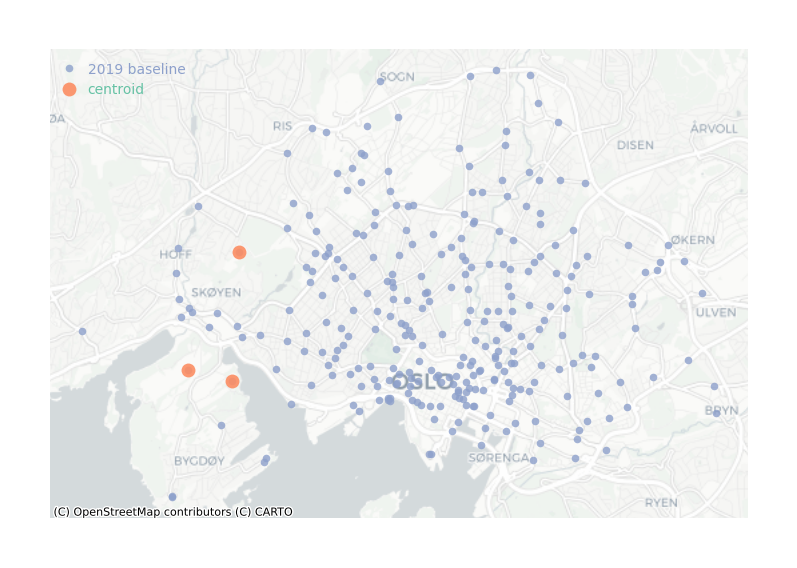

In [103]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_input.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
new_stations.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')


ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

In [86]:
# third point of new stations 
new_stations_third_row = new_stations[-2:-1]
new_stations_third_row

geometry
0  POINT (1187488.663 8380461.971)

In [87]:
new_stations_third_row['on_land'] = new_stations_third_row['geometry'].apply(lambda x: any(x.within(polygon) for polygon in gdf_land['geometry']))
new_stations_third_row

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


geometry  on_land
0  POINT (1187488.663 8380461.971)     True

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_84099/1346736608.py:11: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ocean.plot(ax=ax, color='blue')


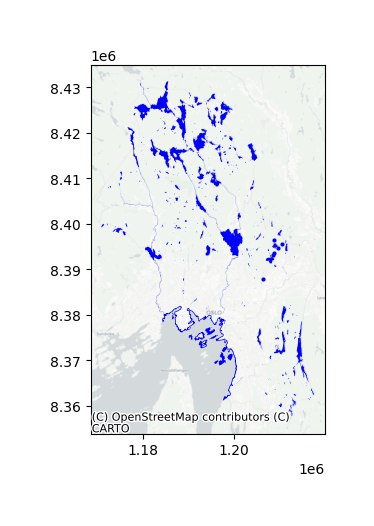

In [80]:
import matplotlib.pyplot as plt
import contextily as cx

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the GeoDataFrame for water bodies
gdf_water.plot(ax=ax, color='blue')

# Plot the GeoDataFrame for the ocean
ocean.plot(ax=ax, color='blue')

# Add the basemap
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [119]:
k = 4

# unique stations of 2024
stations_2024 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')
stations_2024

station_id        station_name              station_description  \
6360135         403           Parkveien                ved trikkestoppet   
6360136         464         Sukkerbiten                    ved gangbroen   
6360137         426          Gimle Kino                ved Frogner Kirke   
6360138         394   Bjølsen Studentby                ved rundkjøringen   
6360139         521  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6394825         545         Arkaden Sør           langs Dronningens gate   
6398328         551     Olaf Ryes plass             langs Sofienberggata   
6422242         576    Dronningens gate               sør for Karl Johan   
6833639         508   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862         549        Linaaes gate                 langs Møllergata   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476      4    24  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764      4    24  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376      4    24  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121      4    24  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394      4    24  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6394825  59.911969  10.747858      4    24  POINT (1196446.113 8380164.804)  
6398328  59.922425  10.758182      4    24  POINT (1197595.342 8382486.885)  
6422242  59.911392  10.747282      4    24  POINT (1196381.941 8380036.728)  
6833639  59.929857  10.714566      2    24  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704      1    24  POINT (1196206.351 8380576.678)  

[268 rows x 8 columns]

In [120]:
import geopandas as gpd
from shapely.geometry import Polygon

# Step 1: Calculate the nearest neighbors
distances = stations_2024.geometry.apply(lambda x: stations_2024.distance(x))
distances.name = "distance"
nearest = distances.apply(lambda x: x.nsmallest(k+1).iloc[-1])
nearest.name = "nearest"

# Step 2: Create polygons
polygons = []
for station in stations_2024.itertuples():
    neighbors = distances.loc[station.Index].nsmallest(k+1).index
    points = stations_2024.loc[neighbors, 'geometry'].tolist()
    polygon = Polygon(points)
    polygons.append(polygon)

# Step 3: Store polygons in a new GeoDataFrame
gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=stations_2024.crs)
gdf_polygons


geometry
0    POLYGON ((1194511.124 8382340.955, 1194831.836...
1    POLYGON ((1197103.483 8378645.102, 1197228.284...
2    POLYGON ((1192050.941 8381344.349, 1192102.616...
3    POLYGON ((1197811.205 8387231.202, 1197833.775...
4    POLYGON ((1196951.014 8381645.305, 1197229.769...
..                                                 ...
263  POLYGON ((1196446.113 8380164.804, 1196467.754...
264  POLYGON ((1197595.342 8382486.885, 1197288.701...
265  POLYGON ((1196381.941 8380036.728, 1196483.884...
266  POLYGON ((1192740.058 8384137.907, 1192641.580...
267  POLYGON ((1196206.351 8380576.678, 1196323.916...

[268 rows x 1 columns]

In [121]:
# Calculate the area of each polygon
gdf_polygons['area'] = gdf_polygons['geometry'].area

# Find the top 5 polygons with the largest area
largest_polygons = gdf_polygons.nlargest(5, 'area')
largest_polygons

geometry          area
128  POLYGON ((1203843.965 8379546.450, 1203782.081...  2.384127e+06
18   POLYGON ((1189653.921 8379211.146, 1190901.363...  2.096225e+06
52   POLYGON ((1191545.243 8387001.069, 1192275.384...  2.016145e+06
23   POLYGON ((1185677.032 8381906.024, 1188520.355...  1.902890e+06
242  POLYGON ((1194219.110 8389077.730, 1194744.194...  1.720212e+06

In [122]:
# Calculate the centroid of the largest polygon
largest_polygon_centroid = largest_polygons['geometry'].centroid
print(largest_polygon_centroid)
print(stations_2024.crs)

128    POINT (1202760.395 8380172.557)
18     POINT (1191052.207 8379543.659)
52     POINT (1192290.962 8386623.281)
23     POINT (1187577.303 8382619.179)
242    POINT (1193747.104 8388019.454)
dtype: geometry
EPSG:3857


In [123]:
# Calculate the centroids of the top 5 largest polygons
largest_polygons_centroids = [polygon['geometry'].centroid for _, polygon in largest_polygons.iterrows()]

# Create a new GeoDataFrame for the centroids
gdf_centroids = gpd.GeoDataFrame({'geometry': largest_polygons_centroids}, crs=stations_2024.crs)

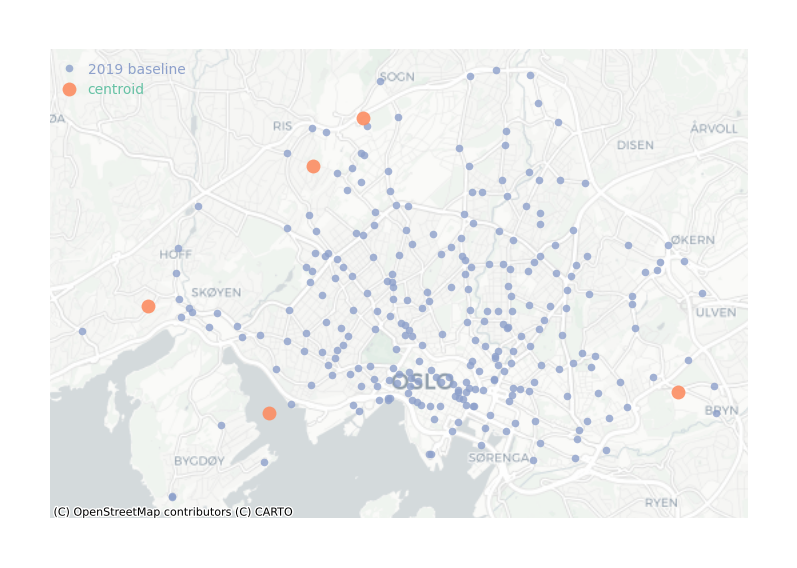

In [124]:
f, ax = plt.subplots(1, figsize=(9, 9))
stations_2024.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
gdf_centroids.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

## Find new stations 2ed try

In [9]:
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')
gdf_stations = create_stations_gdf(df)
# stations_filtered = gdf_stations.drop_duplicates(subset='station_id')

In [7]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations[gdf_stations['year'] == year]

In [8]:
k = 3

# unique stations of 2024
stations_2024 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')
stations_2024

station_id        station_name              station_description  \
6360135         403           Parkveien                ved trikkestoppet   
6360136         464         Sukkerbiten                    ved gangbroen   
6360137         426          Gimle Kino                ved Frogner Kirke   
6360138         394   Bjølsen Studentby                ved rundkjøringen   
6360139         521  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6394825         545         Arkaden Sør           langs Dronningens gate   
6398328         551     Olaf Ryes plass             langs Sofienberggata   
6422242         576    Dronningens gate               sør for Karl Johan   
6833639         508   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862         549        Linaaes gate                 langs Møllergata   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476      4    24  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764      4    24  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376      4    24  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121      4    24  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394      4    24  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6394825  59.911969  10.747858      4    24  POINT (1196446.113 8380164.804)  
6398328  59.922425  10.758182      4    24  POINT (1197595.342 8382486.885)  
6422242  59.911392  10.747282      4    24  POINT (1196381.941 8380036.728)  
6833639  59.929857  10.714566      2    24  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704      1    24  POINT (1196206.351 8380576.678)  

[268 rows x 8 columns]

In [76]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import combinations

# Step 1: Create all possible combinations of k stations
combinations_of_stations = list(combinations(stations_2024.geometry, k))

# Step 2: Create polygons with progress bar
polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

# Step 3: Store polygons in a new GeoDataFrame
gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=stations_2024.crs)
gdf_polygons

100%|██████████| 3280455/3280455 [03:26<00:00, 15884.48it/s]


geometry
0        POLYGON ((1194511.124 8382340.955, 1197103.483...
1        POLYGON ((1194511.124 8382340.955, 1197103.483...
2        POLYGON ((1194511.124 8382340.955, 1197103.483...
3        POLYGON ((1194511.124 8382340.955, 1197103.483...
4        POLYGON ((1194511.124 8382340.955, 1197103.483...
...                                                    ...
3280450  POLYGON ((1192740.058 8384137.907, 1192988.920...
3280451  POLYGON ((1196206.351 8380576.678, 1187488.663...
3280452  POLYGON ((1196206.351 8380576.678, 1187488.663...
3280453  POLYGON ((1196206.351 8380576.678, 1192988.920...
3280454  POLYGON ((1187488.663 8380461.971, 1192988.920...

[3280455 rows x 1 columns]

In [77]:
# Calculate the centroids of all polygons
gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

In [78]:
c = 3
from scipy.spatial import cKDTree
import numpy as np

# Step 1: Calculate the distance from each centroid to its closest c stations
tree = cKDTree(np.array(list(zip(stations_2024.geometry.x, stations_2024.geometry.y))))
distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), k=c)

# Step 2: Find the 5 centroid points that have the largest minimum distance to the c closest stations
min_distances = distances.min(axis=1)
furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-1:]]

In [79]:
furthest_centroids

3191569    POINT (1190094.577 8384004.735)
Name: centroid, dtype: geometry

In [80]:
# Create a new GeoDataFrame for furthest_centroids
gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=stations_2024.crs)

In [72]:
# rename centroid to geometry
gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

In [73]:
# Add the new points to stations_2024
stations_2024 = pd.concat([stations_2024, gdf_furthest_centroids])

In [74]:
stations_2024

station_id        station_name              station_description  \
6360135       403.0           Parkveien                ved trikkestoppet   
6360136       464.0         Sukkerbiten                    ved gangbroen   
6360137       426.0          Gimle Kino                ved Frogner Kirke   
6360138       394.0   Bjølsen Studentby                ved rundkjøringen   
6360139       521.0  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6833639       508.0   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862       549.0        Linaaes gate                 langs Møllergata   
773509          NaN                 NaN                              NaN   
1136425         NaN                 NaN                              NaN   
787734          NaN                 NaN                              NaN   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476    4.0  24.0  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764    4.0  24.0  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376    4.0  24.0  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121    4.0  24.0  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394    4.0  24.0  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6833639  59.929857  10.714566    2.0  24.0  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704    1.0  24.0  POINT (1196206.351 8380576.678)  
773509         NaN        NaN    NaN   NaN  POINT (1187488.663 8380461.971)  
1136425        NaN        NaN    NaN   NaN  POINT (1192988.920 8377864.960)  
787734         NaN        NaN    NaN   NaN  POINT (1187404.949 8378749.276)  

[271 rows x 8 columns]

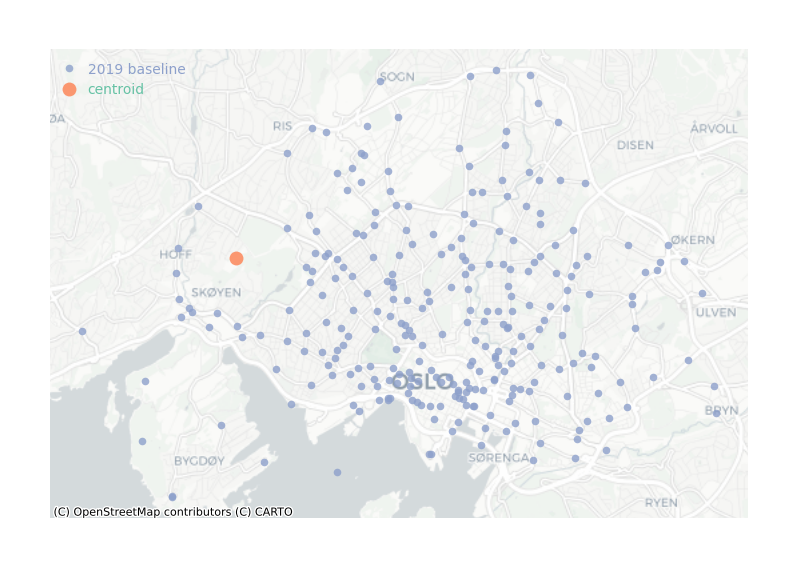

In [82]:
f, ax = plt.subplots(1, figsize=(9, 9))
stations_2024.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
gdf_furthest_centroids.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

In [10]:
# get first point of stations 24
first_station = stations_2024.iloc[0]
first_station

station_id                                                     403
station_name                                             Parkveien
station_description                              ved trikkestoppet
latitude                                                 59.921768
longitude                                                10.730476
month                                                            4
year                                                            24
geometry               POINT (1194511.124289443 8382340.954972156)
Name: 6360135, dtype: object

In [17]:
import osmnx as ox

# Define the area of interest
area_of_interest = 'Oslo, Norway'

# Download the OSM data for water in the area of interest
gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})

# Check if the points are in water
first_station['in_water'] = any(first_station['geometry'].within(polygon) for polygon in gdf_water['geometry'])
first_station

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/3992512386.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/3992512386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_station['in_water'] = any(first_station['geometry'].within(polygon) for polygon in gdf_water['geometry'])


station_id                                                     403
station_name                                             Parkveien
station_description                              ved trikkestoppet
latitude                                                 59.921768
longitude                                                10.730476
month                                                            4
year                                                            24
geometry               POINT (1194511.124289443 8382340.954972156)
in_water                                                     False
Name: 6360135, dtype: object